## Implement pure SVD in surprise

Here I implement a simple recommendation algorithms that uses plain SVD (no regularization, no SGD, etc...).
The only parameter to set is the number of singular values to keep (which can be done by grid search)

In [14]:
from surprise import AlgoBase
from surprise import Dataset
from surprise.model_selection import cross_validate

class poorman_SVD(AlgoBase):

    def __init__(self,n_factors=10,biased=True,verbose=True,NMF=False):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k=n_factors
        self.biased=biased
        self.verbose=verbose
        self.do_NMF=NMF
        if(self.do_NMF): self.biased=False

    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        
        import numpy as np
        from  scipy.sparse import coo_matrix

        #baselines
        if (self.biased): self.bu, self.bi = self.compute_baselines()
        self.mean=trainset.global_mean
        
        #SVD part
        if(self.k>0):
            
            #builds sparse matrix
            if (self.biased): self.ratings=np.array([r-self.mean-self.bu[u]-self.bi[i] 
                                                     for (u, i, r) in self.trainset.all_ratings()])
            else:             self.ratings=np.array([r                                 
                                                     for (_, _, r) in self.trainset.all_ratings()])
            self.users=np.array([u for (u, _, _) in self.trainset.all_ratings()])
            self.items=np.array([i for (_, i, _) in self.trainset.all_ratings()])
            self.user_item=coo_matrix((self.ratings,(self.users,self.items)))

            #performs SVD on sparse matrix
            if(not self.do_NMF):
                if (self.verbose): print('performing SVD with n_factors=', self.k)
                from  scipy.sparse.linalg import svds
                self.U,self.s,self.VT=svds(self.user_item,k=self.k)
                self.S = np.diag(self.s)
                #reconstruct the rating matrix (which is a full matrix n_user*n_items, 
                #good for estimate speed, bad for memory)
                #(this should be technically in the estimate part)
                self.pred_rat=np.dot(self.U, np.dot(self.S, self.VT))

                    
            #performs NMF on full matrix (don"t know if there is a version for sparse matrices)
            else:
                if (self.verbose): print('performing NMF with n_factors=', self.k)
                from sklearn.decomposition import NMF
                self.model = NMF(n_components=self.k, init='random', random_state=0)
                self.pred_rat = self.model.fit_transform(self.user_item.toarray())
        
        return self

    def estimate(self, u, i):
        try:
            if (self.biased):return self.pred_rat[u,i]+self.mean+self.bu[u]+self.bi[i]
            else:            return self.pred_rat[u,i] #+self.mean

        except: 
            try:
                if (self.biased):return self.mean+self.bu[u]+self.bi[i]
                else:            return self.mean
            except:
                return self.mean

        

In [15]:
from surprise import Dataset
from surprise import evaluate

data = Dataset.load_builtin('ml-100k')
#data = Dataset.load_builtin('ml-1m')
data.split(n_folds=4)

In [16]:
algo4 = poorman_SVD(n_factors=1)

# Evaluate performances of our algorithm on the dataset.
perf4 = evaluate(algo4, data, measures=['RMSE', 'MAE','FCP'])

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE, FCP of algorithm poorman_SVD.

------------
Fold 1
Estimating biases using als...
performing SVD with n_factors= 1
RMSE: 0.9425
MAE:  0.7438
FCP:  0.7041
------------
Fold 2
Estimating biases using als...
performing SVD with n_factors= 1
RMSE: 0.9384
MAE:  0.7430
FCP:  0.7100
------------
Fold 3
Estimating biases using als...
performing SVD with n_factors= 1
RMSE: 0.9399
MAE:  0.7444
FCP:  0.7066
------------
Fold 4
Estimating biases using als...
performing SVD with n_factors= 1
RMSE: 0.9326
MAE:  0.7392
FCP:  0.7110
------------
------------
Mean RMSE: 0.9383
Mean MAE : 0.7426
Mean FCP : 0.7079
------------
------------


In [7]:
params={'n_factors':range(0,20),
       }

from surprise.model_selection.search import GridSearchCV
grid4=GridSearchCV(poorman_SVD, params,cv=4, measures=['rmse','fcp'], n_jobs=1, joblib_verbose=10,refit=True)
grid4.fit(data)

Estimating biases using als...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


Estimating biases using als...
performing SVD with n_factors= 1


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


Estimating biases using als...
performing SVD with n_factors= 1


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


Estimating biases using als...
performing SVD with n_factors= 1


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.2s remaining:    0.0s


Estimating biases using als...
performing SVD with n_factors= 1


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.9s remaining:    0.0s


Estimating biases using als...
performing SVD with n_factors= 2


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.6s remaining:    0.0s


Estimating biases using als...
performing SVD with n_factors= 2
Estimating biases using als...
performing SVD with n_factors= 2
Estimating biases using als...
performing SVD with n_factors= 2
Estimating biases using als...
performing SVD with n_factors= 3
Estimating biases using als...
performing SVD with n_factors= 3
Estimating biases using als...
performing SVD with n_factors= 3
Estimating biases using als...
performing SVD with n_factors= 3
Estimating biases using als...
performing SVD with n_factors= 4
Estimating biases using als...
performing SVD with n_factors= 4
Estimating biases using als...
performing SVD with n_factors= 4
Estimating biases using als...
performing SVD with n_factors= 4
Estimating biases using als...
performing SVD with n_factors= 5
Estimating biases using als...
performing SVD with n_factors= 5
Estimating biases using als...
performing SVD with n_factors= 5
Estimating biases using als...
performing SVD with n_factors= 5
Estimating biases using als...
performin

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   56.7s finished


Estimating biases using als...
performing SVD with n_factors= 6


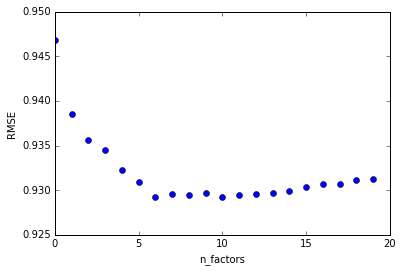

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(grid4.cv_results['param_n_factors'],grid4.cv_results['mean_test_rmse'],'o');
plt.xlabel('n_factors')
plt.ylabel('RMSE');

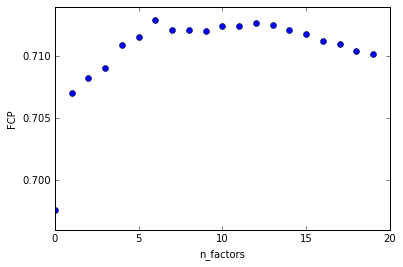

In [20]:
plt.plot(grid4.cv_results['param_n_factors'],grid4.cv_results['mean_test_fcp'],'o');
plt.xlabel('n_factors')
plt.ylabel('FCP');

In [12]:
grid4.best_params,grid4.best_score

({'fcp': {'n_factors': 6}, 'rmse': {'n_factors': 6}},
 {'fcp': 0.7128998856257938, 'rmse': 0.9292604266465252})

Some benchmarks

In [13]:
'''This module runs a 5-Fold CV for all the algorithms (default parameters) on
the movielens datasets, and reports average RMSE, MAE, and total computation
time.  It is used for making tables in the README.md file'''

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import time
import datetime
import random

import numpy as np
import six
from tabulate import tabulate

from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

# The algorithms to cross-validate
classes = (SVD,  poorman_SVD, BaselineOnly, NormalPredictor,NMF, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline,
           CoClustering)

# set RNG
np.random.seed(0)
random.seed(0)

dataset = 'ml-100k'
data = Dataset.load_builtin(dataset)
kf = KFold(random_state=0)  # folds will be the same for all algorithms.

table = []
for klass in classes:
    print(klass.__name__)
    start = time.time()
    out = cross_validate(klass(), data, ['rmse', 'mae','fcp'], kf,n_jobs=1)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae']))
    mean_fcp = '{:.3f}'.format(np.mean(out['test_fcp']))

    new_line = [klass.__name__,mean_rmse, mean_mae, mean_fcp,cv_time]
    print(tabulate([new_line], tablefmt="pipe"))  # print current algo perf
    table.append(new_line)

header = ['Class','RMSE','MAE','FCP','Time']
print(tabulate(table, header, tablefmt="pipe"))

SVD
|:----|------:|------:|----:|:--------|
| SVD | 0.936 | 0.738 | 0.7 | 0:00:22 |
poorman_SVD
Estimating biases using als...
performing SVD with n_factors= 10
Estimating biases using als...
performing SVD with n_factors= 10
Estimating biases using als...
performing SVD with n_factors= 10
Estimating biases using als...
performing SVD with n_factors= 10
Estimating biases using als...
performing SVD with n_factors= 10
|:------------|------:|------:|-----:|:--------|
| poorman_SVD | 0.928 | 0.732 | 0.71 | 0:00:03 |
BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
|:-------------|------:|------:|------:|:--------|
| BaselineOnly | 0.944 | 0.748 | 0.696 | 0:00:03 |
NormalPredictor
|:----------------|------:|------:|------:|:--------|
| NormalPredictor | 1.523 | 1.225 | 0.496 | 0:00:02 |
NMF
|:----|------:|------:|-----:|:--------|
| NMF | 0.963 | 0.757 | 0.69 | 0:00:26 |
S